Intro (...)

In [1]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import multi_tensor

from pca_utils import (rfiw_phantom, mp_distribution)

In [2]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

# Let see if the PCA preserves the multi-shell information

# Sample 8 diffusion-weighted directions for first shell
n_pts = 8
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions8 = hsph_updated.vertices  # directions for each shell

# Sample 30 diffusion-weighted directions for second shell
n_pts = 30
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions30 = hsph_updated.vertices  # directions for each shell

# Sample 60 diffusion-weighted directions for second shell
n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions60 = hsph_updated.vertices  # directions for each shell

# Create full dataset parameters
# (6 b-values = 0, 8 directions for b-value 300, 30 directions for b-value 1000
# and 60 directions for b-value 2000)
bvals = np.hstack((np.zeros(6), 300 * np.ones(8),
                   1000 * np.ones(30), 2000 * np.ones(60)))
bvecs = np.vstack((np.zeros((6, 3)), directions8, directions30, directions60))
gtab = gradient_table(bvals, bvecs)

In [3]:
DWI = rfiw_phantom(gtab, snr=15)

In [4]:
psize = 2
m = (2*psize + 1) ** 3
n = DWI.shape[3]
k = j = i = 5
X = DWI[i - psize: i + psize + 1, j - psize: j + psize + 1,
        k - psize: k + psize + 1, :]
X = X.reshape(m, n)
M = np.mean(X, axis=0)
X = X - M
[L, W] = np.linalg.eigh(np.dot(X.T, X)/m)

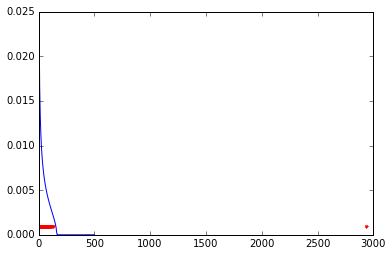

In [7]:
sigma = 100.0/15
y = n*1.0/m
x = np.linspace(0, 500, num=100)
p = mp_distribution(x, sigma ** 2, y)
plt.plot(x, p, 'b', L, 0.001*np.ones(L.shape), '.r')
plt.show()

In [8]:
L

array([  2.05245704e-01,   2.67376311e-01,   4.44282954e-01,
         7.11175117e-01,   7.85213208e-01,   9.72463513e-01,
         1.22733954e+00,   1.48235458e+00,   1.74874176e+00,
         2.14800973e+00,   2.29441746e+00,   2.60029500e+00,
         2.82532015e+00,   3.04108459e+00,   3.05710762e+00,
         3.34115595e+00,   3.80010305e+00,   3.96591135e+00,
         4.35684466e+00,   4.79917276e+00,   5.08630486e+00,
         5.24890948e+00,   5.36699184e+00,   5.94364267e+00,
         6.26896329e+00,   6.74512631e+00,   7.00736087e+00,
         7.37034617e+00,   8.17357483e+00,   8.33056619e+00,
         8.97661728e+00,   9.69229973e+00,   1.01011141e+01,
         1.03545160e+01,   1.10111484e+01,   1.13231476e+01,
         1.21118689e+01,   1.31588074e+01,   1.36366483e+01,
         1.40700212e+01,   1.45333560e+01,   1.46904906e+01,
         1.56057582e+01,   1.60948722e+01,   1.72259225e+01,
         1.78152265e+01,   1.82348011e+01,   1.86960415e+01,
         1.89027458e+01,

In [9]:
DWI = rfiw_phantom(gtab, snr=None)

In [12]:
psize = 2
m = (2*psize + 1) ** 3
n = DWI.shape[3]
k = j = i = 2
X = DWI[i - psize: i + psize + 1, j - psize: j + psize + 1,
        k - psize: k + psize + 1, :]
X = X.reshape(m, n)
M = np.mean(X, axis=0)
X = X - M
[L, W] = np.linalg.eigh(np.dot(X.T, X)/m)

In [13]:
L

array([ -3.01694949e-13,  -2.39078454e-13,  -1.52650897e-13,
        -1.31882616e-13,  -1.14824842e-13,  -1.09975981e-13,
        -1.09895453e-13,  -1.05065719e-13,  -1.00907834e-13,
        -9.68469838e-14,  -8.27613751e-14,  -8.09004907e-14,
        -7.71926341e-14,  -7.03839325e-14,  -6.67704767e-14,
        -6.61917942e-14,  -6.60037979e-14,  -6.15511903e-14,
        -5.28660520e-14,  -4.86471205e-14,  -4.75336084e-14,
        -4.35555271e-14,  -3.95622456e-14,  -3.72790461e-14,
        -3.70797547e-14,  -3.58147797e-14,  -3.21754611e-14,
        -3.08831005e-14,  -2.92855350e-14,  -2.51825983e-14,
        -2.49231897e-14,  -2.31028716e-14,  -2.18223488e-14,
        -2.01144518e-14,  -1.83010508e-14,  -1.76575431e-14,
        -1.57122906e-14,  -1.54733265e-14,  -1.28091852e-14,
        -1.24044595e-14,  -1.19001730e-14,  -1.15489533e-14,
        -8.33318345e-15,  -7.66381495e-15,  -7.40430148e-15,
        -4.94223220e-15,  -4.80010081e-15,  -4.63105883e-15,
        -3.12583525e-15,